In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model as lm
from sklearn import model_selection as ms
sklearn.set_config(print_changed_only=False)

import copy

import import_ipynb

from _Self_Written_Functions_Sheet import (conditions_edit, nbrhd_rank, drop_nbrhd,
totallivsf_add, drop_grlivarea, bsmtfin_add, drop_bsmtfinsf12, totalporchsf_add,
drop_porches, yrsremodtosold_add, drop_yrsoldremod, fireplace_yes, drop_fireplaces,
pool_yes, drop_poolarea, totalbaths_add, drop_baths, totalbsmtbaths_add,
drop_bsmtbaths)

from _Self_Written_Functions_Sheet import (dum_scale, use_og_data, comb_list_generator,
                                           apply_comb_list, rmse)

importing Jupyter notebook from _Self_Written_Functions_Sheet.ipynb


In [2]:
hp_train = pd.read_csv('..\hp_2a_ranked_edited_train.csv', index_col=0)
hp_test = pd.read_csv('..\hp_2a_ranked_edited_test.csv', index_col=0)
hp_logsp = pd.read_csv('..\hp_1a_no_imputation_logsaleprice.csv', index_col=0)
hp_saleprice = pd.read_csv('..\hp_1a_no_imputation_saleprice.csv', index_col=0)

# saving train index
hp_index = hp_train.index
pred_index = hp_test.index

combo_nonedit = pd.concat([hp_train, hp_test])
combo_nonedit.columns = hp_train.columns

# convert all possible numeric types to numeric
for col in combo_nonedit.columns: 
    combo_nonedit[col] = combo_nonedit[col].astype('float', errors='ignore')

combo_cols = list(combo_nonedit.columns)

combo = copy.deepcopy(combo_nonedit)

combo

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,2_STORY_1946_NEWER,RL,65.0,8450.0,1.0,0.0,Reg,Lvl,3.0,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2003.0,2003.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4.0,3.0,PConc,4.0,3.0,1.0,6.0,706.0,1.0,0.0,150.0,856.0,GasA,5.0,1.0,5.0,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,4.0,8.0,7.0,0.0,None,Attchd,2003.0,2.0,2.0,548.0,3.0,3.0,3.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,2.0,2008.0,WD,Normal
1,1_STORY_1946_NEWER_ALL_STYLES,RL,80.0,9600.0,1.0,0.0,Reg,Lvl,3.0,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6.0,8.0,1976.0,1976.0,Gable,CompShg,MetalSd,MetalSd,None,0.0,3.0,3.0,CBlock,4.0,3.0,4.0,5.0,978.0,1.0,0.0,284.0,1262.0,GasA,5.0,1.0,5.0,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,3.0,6.0,7.0,1.0,TA,Attchd,1976.0,2.0,2.0,460.0,3.0,3.0,3.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,5.0,2007.0,WD,Normal
2,2_STORY_1946_NEWER,RL,68.0,11250.0,1.0,0.0,IR1,Lvl,3.0,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2001.0,2002.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4.0,3.0,PConc,4.0,3.0,2.0,6.0,486.0,1.0,0.0,434.0,920.0,GasA,5.0,1.0,5.0,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,4.0,6.0,7.0,1.0,TA,Attchd,2001.0,2.0,2.0,608.0,3.0,3.0,3.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,9.0,2008.0,WD,Normal
3,2_STORY_1945_OLDER,RL,60.0,9550.0,1.0,0.0,IR1,Lvl,3.0,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7.0,5.0,1915.0,1970.0,Gable,CompShg,Wd Sdng,WdShing,None,0.0,3.0,3.0,BrkTil,3.0,4.0,1.0,5.0,216.0,1.0,0.0,540.0,756.0,GasA,4.0,1.0,5.0,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,4.0,7.0,7.0,1.0,Gd,Detchd,1998.0,1.0,3.0,642.0,3.0,3.0,3.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,0.0,None,0.0,2.0,2006.0,WD,Abnorml
4,2_STORY_1946_NEWER,RL,84.0,14260.0,1.0,0.0,IR1,Lvl,3.0,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8.0,5.0,2000.0,2000.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4.0,3.0,PConc,4.0,3.0,3.0,6.0,655.0,1.0,0.0,490.0,1145.0,GasA,5.0,1.0,5.0,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,4.0,9.0,7.0,1.0,TA,Attchd,2000.0,2.0,3.0,836.0,3.0,3.0,3.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,12.0,2008.0,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,2_STORY_PUD_1946_NEWER,RM,21.0,1936.0,1.0,0.0,Reg,Lvl,3.0,Inside,Gtl,MeadowV,Norm,Norm,TwnhsI,2Story,4.0,7.0,1970.0,1970.0,Gable,CompShg,CemntBd,CemntBd,None,0.0,3.0,3.0,CBlock,3.0,3.0,1.0,1.0,0.0,1.0,0.0,546.0,546.0,GasA,4.0,1.0,5.0,546.0,546.0,0.0,1092.0,0.0,0.0,1.0,1.0,3.0,1.0,3.0,5.0,7.0,0.0,None,None,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,6.0,2006.0,WD,Normal
2913,2_STORY_PUD_1946_NEWER,RM,21.0,1894.0,1.0,0.0,Reg,Lvl,3.0,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4.0,5.0,1970.0,1970.0,Gable,CompShg,CemntBd,CemntBd,None,0.0,3.0,3.0,CBlock,3.0,3.0,1.0,3.0,252.0,1.0,0.0,294.0,546.0,GasA,3.0,1.0,5.0,546.0,546.0,0.0,1092.0,0.0,0.0,1.0,1.0,3.0,1.0,3.0,6.0,7.0,0.0,None,CarPort,1970.0,1.0,1.0,286.0,3.0,3.0,3.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,4.0,20

# MLR

In [3]:
# make copies of the original df to edit each individually according to the best scores/feat eng pair
lm_df = copy.deepcopy(combo_nonedit)

# copy and paste the functions from the dictionary results from 3a_Adding_New_Cols_CPU_WORKING
lm_feat_eng = [totalporchsf_add, yrsremodtosold_add, fireplace_yes, pool_yes, totalbsmtbaths_add, 
               conditions_edit, drop_grlivarea, drop_porches, drop_yrsoldremod, drop_fireplaces,
               drop_baths, drop_bsmtbaths]

for feat in lm_feat_eng:
    feat(lm_df)
    
# dummify and scale the dataset
hp_full_strd = copy.deepcopy(dum_scale(lm_df))

hp_full_strd_to_use = copy.deepcopy(hp_full_strd.loc[hp_index])

hp_pred = copy.deepcopy(hp_full_strd.loc[pred_index])
    
state = 0

# setting up train and test sets
xtrain, xtest, ytrain, ytest = ms.train_test_split(hp_full_strd_to_use,
                                                   hp_logsp,
                                                   test_size=0.2,
                                                   random_state=state)

# Must flatten to fit
ytrain = ytrain.values.flatten()

# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)
    
lm = LinearRegression()

# parameters to use
fitintercept = [False]
gparam_mlr_1 = {'fit_intercept': fitintercept}

# setting parameters
gs_mlr_1 = ms.GridSearchCV(lm, gparam_mlr_1, cv=n_folds, refit=True, n_jobs=-1,
                           scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_mlr_1.fit(xtrain, ytrain)

pred_df = pd.DataFrame(gs_mlr_1.predict(hp_pred))

# reset the index to add a column with index values to add the ID numbers
pred_df = pred_df.reset_index()
pred_df['index'] = pred_df['index'] + 1461

# rename columns
pred_df.columns = ['Id', 'SalePrice']

# convert SalePrice back to non-log float
pred_df['SalePrice'] = np.exp(pred_df['SalePrice'])

# convert to csv
pred_df.to_csv('PREDICTIONS_mlr_3.csv', index=False, encoding='utf-8')

pred_df

Wall time: 1.44 s


,Id,SalePrice
0,1461,117059.516866
1,1462,160110.542988
2,1463,177019.583637
3,1464,202688.725248
4,1465,199518.689549
...,...,...
1454,2915,81688.377407
1455,2916,77729.097211
1456,2917,167531.019955
1457,2918,111289.725395


In [ ]:
# Scored 0.14877

# Lasso

In [7]:
# make copies of the original df to edit each individually according to the best scores/feat eng pair
lasso_df = copy.deepcopy(combo_nonedit)

# copy and paste the functions from the dictionary results from 3a_Adding_New_Cols_CPU_WORKING
lasso_feat_eng = [nbrhd_rank, totallivsf_add, totalporchsf_add, fireplace_yes, conditions_edit,
                  drop_grlivarea, drop_bsmtfinsf12, drop_fireplaces, drop_baths, drop_bsmtbaths]

for feat in lasso_feat_eng:
    feat(lasso_df)
    
# dummify and scale the dataset
hp_full_strd = copy.deepcopy(dum_scale(lasso_df))

hp_full_strd_to_use = copy.deepcopy(hp_full_strd.loc[hp_index])

hp_pred = copy.deepcopy(hp_full_strd.loc[pred_index])

state = 0

# setting up train and test sets
xtrain, xtest, ytrain, ytest = ms.train_test_split(hp_full_strd_to_use,
                                                   hp_logsp,
                                                   test_size=0.2,
                                                   random_state=state)

# Must flatten to fit
ytrain = ytrain.values.flatten()

# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)

lasso = Lasso(random_state=state, max_iter=1000000, selection='random')

# parameters to use
alphas = [0.000406]
fitintercept = [True]
warmstart = [True]

gparam_lasso_1 = {'alpha': alphas,
                  'fit_intercept': fitintercept,
                  'warm_start': warmstart}

# setting parameters
gs_lasso_1 = ms.GridSearchCV(lasso, gparam_lasso_1, cv=n_folds, refit=True, n_jobs=-1,
                      scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_lasso_1.fit(xtrain, ytrain)

pred_df = pd.DataFrame(gs_lasso_1.predict(hp_pred))

# reset the index to add a column with index values to add the ID numbers
pred_df = pred_df.reset_index()
pred_df['index'] = pred_df['index'] + 1461

# rename columns
pred_df.columns = ['Id', 'SalePrice']

# convert SalePrice back to non-log float
pred_df['SalePrice'] = np.exp(pred_df['SalePrice'])

# convert to csv
pred_df.to_csv('PREDICTIONS_lasso_3.csv', index=False, encoding='utf-8')

pred_df

Wall time: 738 ms


,Id,SalePrice
0,1461,109663.215675
1,1462,157559.027669
2,1463,176186.854610
3,1464,200674.022598
4,1465,195516.140927
...,...,...
1454,2915,84833.788191
1455,2916,82170.714753
1456,2917,161244.875137
1457,2918,116550.524832


In [ ]:
# Scored 0.13093

# Enet

In [12]:
# make copies of the original df to edit each individually according to the best scores/feat eng pair
enet_df = copy.deepcopy(combo_nonedit)

# copy and paste the functions from the dictionary results from 3a_Adding_New_Cols_CPU_WORKING
enet_feat_eng = [nbrhd_rank, totallivsf_add, bsmtfin_add, totalporchsf_add, yrsremodtosold_add,
                 conditions_edit, drop_grlivarea, drop_bsmtfinsf12, drop_yrsoldremod, drop_fireplaces,
                 drop_baths, drop_bsmtbaths]

for feat in enet_feat_eng:
    feat(enet_df)
    
# dummify and scale the dataset
hp_full_strd = copy.deepcopy(dum_scale(enet_df))

hp_full_strd_to_use = copy.deepcopy(hp_full_strd.loc[hp_index])

hp_pred = copy.deepcopy(hp_full_strd.loc[pred_index])

state = 0

# setting up train and test sets
xtrain, xtest, ytrain, ytest = ms.train_test_split(hp_full_strd_to_use,
                                                   hp_logsp,
                                                   test_size=0.2,
                                                   random_state=state)

# Must flatten to fit
ytrain = ytrain.values.flatten()

# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)

enet = ElasticNet(max_iter=100000, selection='random', random_state=0)

# parameters to use
alphas = [0.0001]
l1ratio = [1]
warmstart = [True]
gparam_enet_1 = {'alpha': alphas,
                 'l1_ratio': l1ratio,
                 'warm_start': warmstart}

# setting parameters
gs_enet_1 = ms.GridSearchCV(enet, gparam_enet_1, cv=n_folds, refit=True, n_jobs=-1,
                      scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_enet_1.fit(xtrain, ytrain)

pred_df = pd.DataFrame(gs_enet_1.predict(hp_pred))

# reset the index to add a column with index values to add the ID numbers
pred_df = pred_df.reset_index()
pred_df['index'] = pred_df['index'] + 1461

# rename columns
pred_df.columns = ['Id', 'SalePrice']

# convert SalePrice back to non-log float
pred_df['SalePrice'] = np.exp(pred_df['SalePrice'])

# convert to csv
pred_df.to_csv('PREDICTIONS_enet_3.csv', index=False, encoding='utf-8')

pred_df

Wall time: 820 ms


,Id,SalePrice
0,1461,115408.927879
1,1462,160917.724511
2,1463,180017.516663
3,1464,205402.971108
4,1465,200390.160739
...,...,...
1454,2915,82263.062829
1455,2916,76829.276968
1456,2917,164417.097898
1457,2918,113214.867558


In [ ]:
# Scored 0.13523

# Random Forest

In [6]:
# make copies of the original df to edit each individually according to the best scores/feat eng pair
rfr_df = copy.deepcopy(combo_nonedit)

# copy and paste the functions from the dictionary results from 3a_Adding_New_Cols_CPU_WORKING
rfr_feat_eng = [totallivsf_add, bsmtfin_add, yrsremodtosold_add, totalbaths_add, totalbsmtbaths_add,
                 drop_porches, drop_yrsoldremod, drop_fireplaces, drop_poolarea, drop_bsmtbaths]

for feat in rfr_feat_eng:
    feat(rfr_df)
    
# dummify and scale the dataset
hp_full_strd = copy.deepcopy(dum_scale(rfr_df))

hp_full_strd_to_use = copy.deepcopy(hp_full_strd.loc[hp_index])

hp_pred = copy.deepcopy(hp_full_strd.loc[pred_index])

state = 0

# setting up train and test sets
xtrain, xtest, ytrain, ytest = ms.train_test_split(hp_full_strd_to_use,
                                                   hp_logsp,
                                                   test_size=0.2,
                                                   random_state=state)

# Must flatten to fit
ytrain = ytrain.values.flatten()

# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)

rfr = RandomForestRegressor(random_state=0)

# parameters to use
maxdepth = [30]
minsamlf = [1]
minsamsplt = [2]
nestimators = [475]
oobscore = [True]
warmstart = [True]

gparam_rfr_1 = {'max_depth': maxdepth,
                'min_samples_leaf': minsamlf,
                'min_samples_split': minsamsplt,
                'n_estimators': nestimators,
                'oob_score': oobscore,
                'warm_start': warmstart}

# setting parameters
gs_rfr_1 = ms.GridSearchCV(rfr, gparam_rfr_1, cv=n_folds, refit=True, n_jobs=-1,
                      scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_rfr_1.fit(xtrain, ytrain)


sorted_importance_rfr = sorted(zip(hp_full_strd_to_use.columns,
                                   gs_rfr_1.best_estimator_.feature_importances_),
                               key=lambda t:t[1], reverse=True)

filtered_sorted_importance_rfr = [x for x in sorted_importance_rfr if x[1]>0]

df_filter_sort_rfr = [x[0] for x in filtered_sorted_importance_rfr]

hp_fullstrd_filtrsrt = hp_full_strd_to_use[df_filter_sort_rfr]


# setting up train and test sets
xtrain_fs, xtest_fs, ytrain_fs, ytest_fs = ms.train_test_split(hp_fullstrd_filtrsrt,
                                                               hp_logsp,
                                                               test_size=0.2,
                                                               random_state=state)

# Must flatten to fit
ytrain_fs = ytrain_fs.values.flatten()

# parameters to use
maxdepth = [17]
minsamlf = [1]
minsamsplt = [3]
nestimators = [475]
oobscore = [True]
warmstart = [True]


gparam_rfr_fs = {'max_depth': maxdepth,
                  'min_samples_leaf': minsamlf,
                  'min_samples_split': minsamsplt,
                  'n_estimators': nestimators,
                  'oob_score': oobscore,
                  'warm_start': warmstart}
# setting parameters
gs_rfr_fs = ms.GridSearchCV(rfr, gparam_rfr_fs, cv=n_folds, refit=True, n_jobs=-1,
                             scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_rfr_fs.fit(xtrain, ytrain)


pred_df = pd.DataFrame(gs_rfr_fs.predict(hp_pred))

# reset the index to add a column with index values to add the ID numbers
pred_df = pred_df.reset_index()
pred_df['index'] = pred_df['index'] + 1461

# rename columns
pred_df.columns = ['Id', 'SalePrice']

# convert SalePrice back to non-log float
pred_df['SalePrice'] = np.exp(pred_df['SalePrice'])

# convert to csv
pred_df.to_csv('PREDICTIONS_rfr_3.csv', index=False, encoding='utf-8')

pred_df

C:\Users\tdcho\anaconda3\envs\proj3_env\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Wall time: 13.4 s


C:\Users\tdcho\anaconda3\envs\proj3_env\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Wall time: 12.6 s


,Id,SalePrice
0,1461,129425.011106
1,1462,163701.683937
2,1463,181653.593858
3,1464,184923.214029
4,1465,197192.697546
...,...,...
1454,2915,86994.363803
1455,2916,89265.409989
1456,2917,174772.015253
1457,2918,103791.516539


In [ ]:
# score 0.14636

# Gradient Boosting

In [19]:
# make copies of the original df to edit each individually according to the best scores/feat eng pair
gbm_df = copy.deepcopy(combo_nonedit)

# copy and paste the functions from the dictionary results above
gbm_feat_eng = [bsmtfin_add, totalbaths_add, totalbsmtbaths_add, conditions_edit, drop_porches,
                drop_yrsoldremod, drop_poolarea, drop_bsmtbaths]

for feat in gbm_feat_eng:
    feat(gbm_df)

# dummify and scale the dataset
hp_full_strd = copy.deepcopy(dum_scale(gbm_df))

hp_full_strd_to_use = copy.deepcopy(hp_full_strd.loc[hp_index])

gbm_experimental = copy.deepcopy(gbm_df)

# Adding Seasons
experiment = copy.deepcopy(combo)

# to_num = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6,
#           'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}

# experiment['MoSold'] = experiment['MoSold'].map(to_num)

experiment['SeasonSold'] = 'Spring'

experiment.loc[(experiment['MoSold']==6) |
               (experiment['MoSold']==7) | 
               (experiment['MoSold']==8), 'SeasonSold'] = 'Summer'

experiment.loc[(experiment['MoSold']==9) |
               (experiment['MoSold']==10) |
               (experiment['MoSold']==11), 'SeasonSold'] = 'Fall'

experiment.loc[(experiment['MoSold']==12) | 
               (experiment['MoSold']==1) | 
               (experiment['MoSold']==2), 'SeasonSold'] = 'Winter'

# changing combo now so that I could use month number in experiment df
# https://stackoverflow.com/questions/37625334/python-pandas-convert-month-int-to-month-name
import calendar

# Adding Sold Date

experiment[['MoSold', 'YrSold']] = experiment[['MoSold', 'YrSold']].astype(int)

experiment['DateSold'] = pd.to_datetime(experiment.YrSold.astype(str) +\
                                        '-' + experiment.MoSold.astype(str))

experiment['MoSold'] = experiment ['MoSold'].apply(lambda x: calendar.month_abbr[x])

# adding WSJ Prime Rate
# https://en.wikipedia.org/wiki/Wall_Street_Journal_prime_rate
experiment['WSJPrime'] = 0
experiment.loc[experiment['DateSold']>='2005-12-01 00:00:00', 'WSJPrime'] = 7.25
experiment.loc[experiment['DateSold']>='2006-02-01 00:00:00', 'WSJPrime'] = 7.50
experiment.loc[experiment['DateSold']>='2006-04-01 00:00:00', 'WSJPrime'] = 7.75
experiment.loc[experiment['DateSold']>='2006-05-01 00:00:00', 'WSJPrime'] = 8.00
experiment.loc[experiment['DateSold']>='2006-07-01 00:00:00', 'WSJPrime'] = 8.25
experiment.loc[experiment['DateSold']>='2007-09-01 00:00:00', 'WSJPrime'] = 7.75
experiment.loc[experiment['DateSold']>='2007-11-01 00:00:00', 'WSJPrime'] = 7.50
experiment.loc[experiment['DateSold']>='2007-12-01 00:00:00', 'WSJPrime'] = 7.25
experiment.loc[experiment['DateSold']>='2008-01-01 00:00:00', 'WSJPrime'] = 6.50
experiment.loc[experiment['DateSold']>='2008-02-01 00:00:00', 'WSJPrime'] = 6.00
experiment.loc[experiment['DateSold']>='2008-03-01 00:00:00', 'WSJPrime'] = 5.25
experiment.loc[experiment['DateSold']>='2008-05-01 00:00:00', 'WSJPrime'] = 5.00
experiment.loc[experiment['DateSold']>='2008-10-01 00:00:00', 'WSJPrime'] = 4.50
experiment.loc[experiment['DateSold']>='2008-11-01 00:00:00', 'WSJPrime'] = 4.00
experiment.loc[experiment['DateSold']>='2008-12-01 00:00:00', 'WSJPrime'] = 3.25
experiment.loc[experiment['DateSold']>='2015-12-01 00:00:00', 'WSJPrime'] = 3.50

# for experimental dataset
to_paste = experiment[['DateSold', 'WSJPrime', 'MoSold', 'YrSold']]

gbm_df = gbm_df.drop(['MoSold'], axis=1)

new_cols = list(gbm_df.columns) + list(to_paste.columns)

gbm_experiment = pd.DataFrame(np.concatenate((gbm_df, to_paste),
                                             axis=1), columns = new_cols)

# converting columns containing numbers to numeric type
for col in gbm_experiment.columns: 
    gbm_experiment[col] = gbm_experiment[col].astype('float', errors='ignore')

# dummify and scale the dataset
hp_experimental = copy.deepcopy(dum_scale(gbm_experiment))
hp_experimental_to_use = copy.deepcopy(hp_experimental.loc[hp_index])

hp_pred = copy.deepcopy(hp_experimental.loc[pred_index])

state = 0

# setting up train and test sets
xtrain, xtest, ytrain, ytest = ms.train_test_split(hp_experimental_to_use,
                                                   hp_logsp,
                                                   test_size=0.2,
                                                   random_state=state)

# Must flatten to fit
ytrain = ytrain.values.flatten()

# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)

gbm = GradientBoostingRegressor(random_state=0)

# parameters to use
maxdepth = [3]
minsamlf = [2]
minsamsplt = [2]
nestimators = [241]
sub_sample = [0.75]
warmstart = [True]

gparam_gbm = {'n_estimators': nestimators,
              'subsample': sub_sample,
              'min_samples_split': minsamsplt,
              'min_samples_leaf': minsamlf,
              'max_depth': maxdepth,
              'warm_start': warmstart}
# setting parameters
gs_gbm = ms.GridSearchCV(gbm, gparam_gbm, cv=n_folds, refit=True, n_jobs=-1,
                           scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_gbm.fit(xtrain, ytrain)

pred_df = pd.DataFrame(gs_gbm.predict(hp_pred))

# reset the index to add a column with index values to add the ID numbers
pred_df = pred_df.reset_index()
pred_df['index'] = pred_df['index'] + 1461

# rename columns
pred_df.columns = ['Id', 'SalePrice']

# convert SalePrice back to non-log float
pred_df['SalePrice'] = np.exp(pred_df['SalePrice'])

# convert to csv
pred_df.to_csv('PREDICTIONS_gbm_3.csv', index=False, encoding='utf-8')

pred_df

Wall time: 6.4 s


,Id,SalePrice
0,1461,124460.806929
1,1462,156832.502534
2,1463,182874.133998
3,1464,197375.119573
4,1465,195956.830990
...,...,...
1454,2915,83211.888567
1455,2916,72678.455459
1456,2917,155771.155119
1457,2918,115125.522592


In [ ]:
# Scored 0.13016

# XGBoost

In [21]:
import xgboost as xgb

# make copies of the original df to edit each individually according to the best scores/feat eng pair
xgb_df = copy.deepcopy(combo_nonedit)

# copy and paste the functions from the dictionary results from 3a_Adding_New_Cols_CPU_WORKING
xgb_feat_eng = [nbrhd_rank, totallivsf_add, totalporchsf_add, fireplace_yes, drop_yrsoldremod,
                drop_fireplaces, drop_poolarea, drop_bsmtbaths]

for feat in xgb_feat_eng:
    feat(xgb_df)
    
# dummify and scale the dataset
hp_full_strd = copy.deepcopy(dum_scale(xgb_df))

hp_full_strd_to_use = copy.deepcopy(hp_full_strd.loc[hp_index])

hp_pred = copy.deepcopy(hp_full_strd.loc[pred_index])

state = 0

# setting up train and test sets
xtrain, xtest, ytrain, ytest = ms.train_test_split(hp_full_strd_to_use,
                                                   hp_logsp,
                                                   test_size=0.2,
                                                   random_state=state)

# Must flatten to fit
ytrain = ytrain.values.flatten()

# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)

# using GPU
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=state,
                           eval_metric='rmse', verbosity=3, tree_method='gpu_hist',
                           sampling_method='gradient_based')

# setting parameters
learningrate = [0.1]
gamm = [0.01]
sub_sample = [0.75]
lambd = [0.25]
alph = [0.25]

gparam_xgb = {'eta': learningrate,
              'gamma': gamm,
              'subsample': sub_sample,
              'lambda': lambd,
              'alpha': alph}

# setting parameters
gs_xgb_1 = ms.GridSearchCV(xgb_reg, gparam_xgb, cv=n_folds, refit=True, n_jobs=-1,
                           scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_xgb_1.fit(xtrain, ytrain)

pred_df = pd.DataFrame(gs_xgb_1.predict(hp_pred))

# reset the index to add a column with index values to add the ID numbers
pred_df = pred_df.reset_index()
pred_df['index'] = pred_df['index'] + 1461

# rename columns
pred_df.columns = ['Id', 'SalePrice']

# convert SalePrice back to non-log float
pred_df['SalePrice'] = np.exp(pred_df['SalePrice'])

# convert to csv
pred_df.to_csv('PREDICTIONS_xgb_3.csv', index=False, encoding='utf-8')

pred_df

[01:20:47] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_gpu_hist.cu:873: [GPU Hist]: Configure
[01:20:48] ======== Monitor (0): SketchContainer ========
[01:20:48] MakeCuts: 0.000906s, 1 calls @ 906us

[01:20:48] Prune: 0.000556s, 1 calls @ 556us

[01:20:48] ScanInput: 0.00039s, 1 calls @ 390us

[01:20:48] Unique: 0.000353s, 1 calls @ 353us

[01:20:49] ======== Monitor (0): Learner ========
[01:20:49] Configure: 0s, 1 calls @ 0us

[01:20:49] EvalOneIter: 0.000587s, 100 calls @ 587us

[01:20:49] GetGradient: 0.007703s, 100 calls @ 7703us

[01:20:49] PredictRaw: 0.928495s, 100 calls @ 928495us

[01:20:49] UpdateOneIter: 0.599733s, 100 calls @ 599733us

[01:20:49] ======== Monitor (0): GBTree ========
[01:20:49] BoostNewTrees: 0.619705s, 100 calls @ 619705us

[01:20:49] CommitModel: 4.6e-05s, 100 calls @ 46us

[01:20:49] ======== Device 0 Memory Allocations:  ========
[01:20:49] Peak memory usage: 6MiB
[01:20:49] Number of allocations: 7539
[01:20:4

,Id,SalePrice
0,1461,123619.218750
1,1462,164438.531250
2,1463,191873.343750
3,1464,195434.500000
4,1465,195907.359375
...,...,...
1454,2915,84850.742188
1455,2916,81645.078125
1456,2917,174291.312500
1457,2918,113887.046875


In [ ]:
# Score 0.13352

In [3]:
rmse_dict = {'Multilinear Regression':[0.147059, 0.107565, 0.107565, 0.14877],
             'Lasso Regression':[0.102901, 0.105757, 0.102731, 0.13093],
             'ElasticNet Regression':[0.102867, 0.102309, 0.105376, 0.13523],
             'Random Forest Regression':[0.119338, 0.119524, 0.119506, 0.14636],
             'Gradient Boosting Regression':[0.116937, 0.105513, 0.106647, 0.13016],
             'XGBoost Regression': [0.124868, 0.111657, 0.108918, 0.13352]}

rmse_df = pd.DataFrame.from_dict(rmse_dict, orient='index', columns=['Post-Imputation', 
                                                                     'Post-Powerset Permutation', 
                                                                     'Post-Tuning', 'Kaggle Score'])

rmse_df

,Post-Imputation,Post-Powerset Permutation,Post-Tuning,Kaggle Score
Multilinear Regression,0.147059,0.107565,0.107565,0.14877
Lasso Regression,0.102901,0.105757,0.102731,0.13093
ElasticNet Regression,0.102867,0.102309,0.105376,0.13523
Random Forest Regression,0.119338,0.119524,0.119506,0.14636
Gradient Boosting Regression,0.116937,0.105513,0.106647,0.13016
XGBoost Regression,0.124868,0.111657,0.108918,0.13352


In [11]:
rmse_dict = {'Multilinear Regression':[0.147059, 0.107565, 0.107565, 0.14877],
             'Lasso Regression':[0.102901, 0.105757, 0.102731, 0.13093],
             'ElasticNet Regression':[0.102867, 0.102309, 0.105376, 0.13523],
             'Random Forest Regression':[0.119338, 0.119524, 0.119506, 0.14636],
             'Gradient Boosting Regression':[0.116937, 0.105513, 0.106647, 0.13016],
             'XGBoost Regression': [0.124868, 0.111657, 0.108918, 0.13352],
             'Score': ['Post-Imputation',  'Post-Powerset Permutation',  'Post-Tuning',
                       'Kaggle Score']}

rmse_df_2 = pd.DataFrame.from_dict(rmse_dict).set_index('Score')

rmse_df_2

,Multilinear Regression,Lasso Regression,ElasticNet Regression,Random Forest Regression,Gradient Boosting Regression,XGBoost Regression
Score,,,,,,
Post-Imputation,0.147059,0.102901,0.102867,0.119338,0.116937,0.124868
Post-Powerset Permutation,0.107565,0.105757,0.102309,0.119524,0.105513,0.111657
Post-Tuning,0.107565,0.102731,0.105376,0.119506,0.106647,0.108918
Kaggle Score,0.148770,0.130930,0.135230,0.146360,0.130160,0.133520


In [16]:
from matplotlib import pyplot as plt
import seaborn as sns

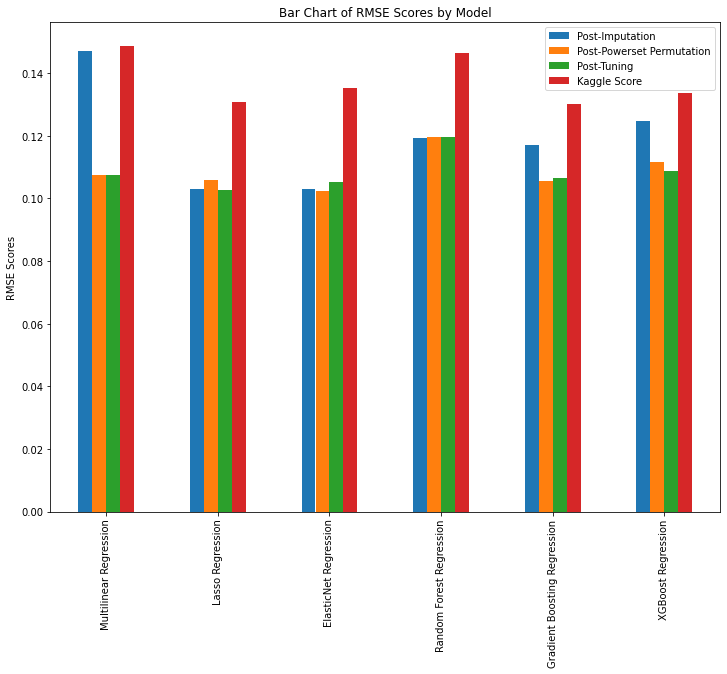

In [20]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 9]
rmse_df.plot.bar()
plt.ylabel('RMSE Scores')
plt.title('Bar Chart of RMSE Scores by Model')
plt.grid(which='both')
plt.grid(which='major')
plt.show()

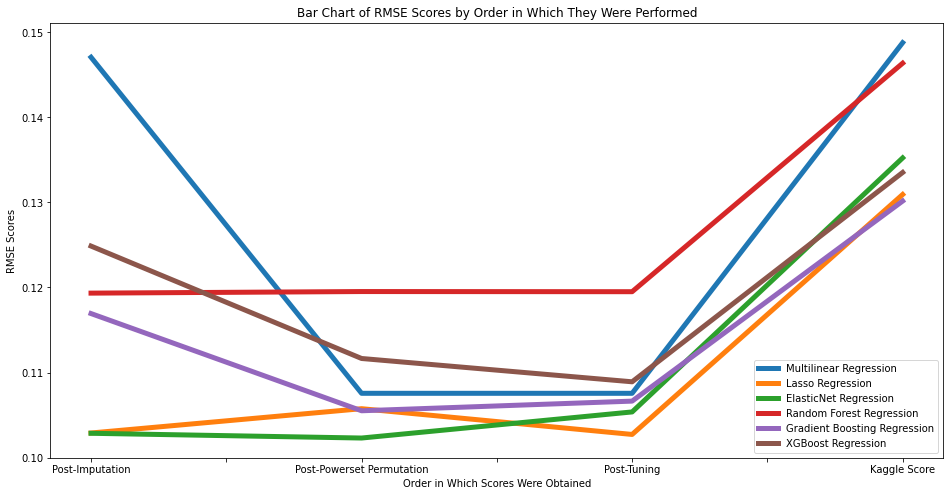

In [22]:
rmse_df_2.plot(figsize=(16, 8), lw=5)
plt.ylabel('RMSE Scores')
plt.xlabel('Order in Which Scores Were Obtained')
plt.title('Bar Chart of RMSE Scores by Order in Which They Were Performed')
plt.grid(which='both')
plt.grid(which='major')